In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import re
import os
import zlib
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sys
import seaborn as sns
from sklearn.cluster import KMeans
import nltk
from langdetect import detect

ModuleNotFoundError: No module named 'langdetect'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV

In [3]:
#pip install xgboost

In [4]:
Spotify = pd.read_csv('SpotifyFeatures.csv')
lyrics = pd.read_csv('only_lyrics.csv')

## Merging lyrics and the songs

In [5]:
Spotify['track_name']=Spotify['track_name'].str.lower()
Spotify['track_name']=Spotify['track_name'].str.strip()
Spotify['artist_name']=Spotify['artist_name'].str.lower()
Spotify['artist_name']=Spotify['artist_name'].str.strip()
lyrics['song']=lyrics['song'].str.lower()
lyrics['song']=lyrics['song'].str.strip()
lyrics['artist']=lyrics['artist'].str.lower()
lyrics['artist']=lyrics['artist'].str.strip()

In [6]:
song_lyrics = Spotify.merge(lyrics, left_on=['track_name', 'artist_name'], right_on=['song', 'artist'])  

In [7]:
song_lyrics =song_lyrics.sort_values(by=['popularity'],ascending=False)
song_lyrics = song_lyrics.reset_index()


In [8]:
song_lyrics=song_lyrics.drop(['index','artist', 'song', 'link'], axis=1)

In [9]:
#clean_lyrics(song_lyrics.iloc[675,-1])

## Pre-processing lyrics

In [10]:
def clean_lyrics(lyrics):
    new_lyrics = re.sub(r'[\(\[].*?[\)\]]', ' ', lyrics)
    new_lyrics = new_lyrics.replace("\n", " ")
    #new_lyrics = new_lyrics.replace(""\"","")
    new_lyrics= new_lyrics.strip()
    new_lyrics= new_lyrics.replace("    ", " ")
    new_lyrics= new_lyrics.replace("   ", " ")
    new_lyrics= new_lyrics.replace("  ", " ")
    new_lyrics = os.linesep.join([s for s in new_lyrics.splitlines() if s])
    return(new_lyrics)

In [11]:
def get_compression_rate(lyrics):
    original = lyrics.encode('utf-8')
    compressed = zlib.compress(original)
    decompressed = zlib.decompress(compressed)
    
    compression_rate = (len(original)-len(compressed))/len(original)
    return compression_rate

In [12]:
#Apply clean_lyrics function to text column
song_lyrics['text'] = song_lyrics['text'].map(clean_lyrics)

#Append new column with compression rate
song_lyrics['compression_rate'] = song_lyrics['text'].map(get_compression_rate)

In [13]:
#Drop duplicates
song_lyrics = song_lyrics.sort_values(by='popularity', ascending=False)
song_lyrics = song_lyrics.drop_duplicates(subset='track_id', keep="first")

#Keep only english songs
song_lyrics['language'] = song_lyrics['text'].map(detect)
song_lyrics = song_lyrics[song_lyrics['language'] =="en"]

NameError: name 'detect' is not defined

In [14]:
song_lyrics.head(1)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,text,compression_rate
0,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,0.000464,E,0.0986,-10.48,Major,0.0476,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. Bu...",0.643378


### Addition of sentment analysis (+,-,=) values

In [15]:
sia=SentimentIntensityAnalyzer()
sentiment = pd.DataFrame(columns=('id','senti_positive', 'senti_neutral', 'senti_negative'))
for i in range(len(song_lyrics['text'])):
    num_positive = 0
    num_negative = 0
    num_neutral = 0
    lyric= song_lyrics.iloc[i,-2]
    for j in lyric.split():
        comp = sia.polarity_scores(j)
        comp = comp['compound']
        #print(test)
        if comp >= 0.5:
            num_positive += 1
            #print('positive:',i)
        elif comp > -0.5 and comp < 0.5:
            num_neutral += 1
        else:
            num_negative += 1
        #print('negative:',i)
    sentiment.loc[i] = (song_lyrics.iloc[i,3],num_positive,num_neutral,num_negative)
#num_total = num_negative + num_neutral + num_positive
#print('Total score:',num_total)
#print('Negative score:',num_negative)
#print('Neutral score:',num_neutral)
#print('Positive score:',num_positive)
sentiment.head()

,id,senti_positive,senti_neutral,senti_negative
0,1HNkqx9Ahdgi1Ixy2xkKkL,6,310,5
1,2374M0fQpWi3dLnB54qaLX,0,268,0
2,1EzrEOXmMH3G43AXT1y7pA,13,295,0
3,34gCuhDGsG4bRPIf9bb02f,16,310,0
4,5Nm9ERjJZ5oyfXZTECKmRt,10,152,1


In [16]:
#sentiment['senti_total']=sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']
sentiment['senti_%+']=(sentiment['senti_positive']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100
sentiment['senti_%-']=(sentiment['senti_negative']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100
sentiment['senti_%=']=(sentiment['senti_neutral']/(sentiment['senti_positive']+sentiment['senti_neutral']+sentiment['senti_negative']))*100
sentiment.head()

,id,senti_positive,senti_neutral,senti_negative,senti_%+,senti_%-,senti_%=
0,1HNkqx9Ahdgi1Ixy2xkKkL,6,310,5,1.86916,1.55763,96.5732
1,2374M0fQpWi3dLnB54qaLX,0,268,0,0,0,100
2,1EzrEOXmMH3G43AXT1y7pA,13,295,0,4.22078,0,95.7792
3,34gCuhDGsG4bRPIf9bb02f,16,310,0,4.90798,0,95.092
4,5Nm9ERjJZ5oyfXZTECKmRt,10,152,1,6.13497,0.613497,93.2515


In [17]:
sentiment['senti_total']=sentiment['senti_positive']-sentiment['senti_negative']

In [18]:
sentiment=sentiment.drop(['senti_positive','senti_neutral', 'senti_negative'], axis=1)

In [19]:
song_lyrics = song_lyrics.merge(sentiment, left_on=['track_id'], right_on=['id'])
song_lyrics.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,tempo,time_signature,valence,text,compression_rate,id,senti_%+,senti_%-,senti_%=,senti_total
0,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,0.000464,...,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. Bu...",0.643378,1HNkqx9Ahdgi1Ixy2xkKkL,1.86916,1.55763,96.5732,1
1,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257,0.671,295893,0.373,0.000080,...,92.717,4/4,0.732,I hear the drums echoing tonight But she hears...,0.637233,2374M0fQpWi3dLnB54qaLX,0,0,100,0
2,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,0.000000,...,150.953,4/4,0.718,Well you done done me and you bet I felt it I ...,0.572757,1EzrEOXmMH3G43AXT1y7pA,4.22078,0,95.7792,13
3,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474,0.781,281560,0.445,0.000000,...,78.998,4/4,0.591,When your legs don't work like they used to be...,0.623063,34gCuhDGsG4bRPIf9bb02f,4.90798,0,95.092,16
4,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588,0.418,172724,0.420,0.000064,...,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night s...",0.640961,5Nm9ERjJZ5oyfXZTECKmRt,6.13497,0.613497,93.2515,9


In [20]:
song_lyrics=song_lyrics.drop(['id'], axis=1)

In [21]:
song=song_lyrics['track_name']
song=song.str.strip()
song=song.str.split()
l=[]
for i in song:
    #print(len(i))
    l.append(len(i))
song_lyrics['track_length']=l 

## Addition of classes

1. Popularity

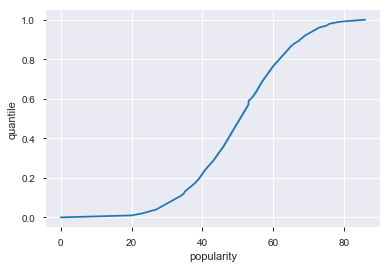

In [22]:
quantile=song_lyrics['popularity'].quantile(np.arange(0, 1.01, 0.01).tolist())
quantile=quantile.reset_index()
quantile.rename(columns={'index':'quantile'}, inplace=True)
sns.lineplot(quantile['popularity'],quantile['quantile'])

In [23]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(quantile)
quantile['cluster']=kmeans.predict(quantile)

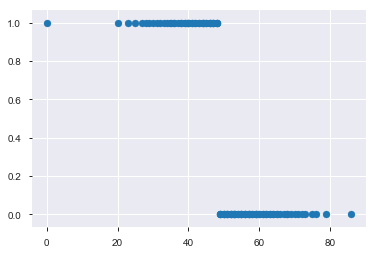

In [24]:
plt.scatter(quantile['popularity'],quantile['cluster'])

In [25]:
quantile

,quantile,popularity,cluster
0,0.00,0.00,1
1,0.01,20.00,1
2,0.02,23.00,1
3,0.03,25.00,1
4,0.04,27.00,1
5,0.05,28.00,1
6,0.06,29.00,1
7,0.07,30.00,1
8,0.08,31.00,1
9,0.09,32.00,1


In [26]:
one=quantile[quantile.cluster==1]
#two=quantile[quantile.cluster==2]
#three=quantile[quantile.cluster==3]
zero=quantile[quantile.cluster==0]
#four=quantile[quantile.cluster==4]
min_one=np.min(one['popularity'])
max_one=np.max(one['popularity'])
#min_two=np.min(two['popularity'])
#max_two=np.max(two['popularity'])
#min_three=np.min(three['popularity'])
#max_three=np.max(three['popularity'])
min_zero=np.min(zero['popularity'])
max_zero=np.max(zero['popularity'])
#min_four=np.min(four['popularity'])
#max_four=np.max(four['popularity'])
print(1,min_one,max_one)
#print(2,min_two,max_two)
#print(3,min_three,max_three)
#print(4,min_four,max_four)
print(0,min_zero,max_zero)

1 0.0 48.0
0 49.0 86.0


In [27]:
conditions = [
    (song_lyrics['popularity'] >= 50)&(song_lyrics['popularity'] <=100),
    (song_lyrics['popularity'] >= 42)&(song_lyrics['popularity'] <=49),
    (song_lyrics['popularity'] >= 38)&(song_lyrics['popularity'] <=41),
    (song_lyrics['popularity'] >= 20)&(song_lyrics['popularity'] <=37),
    (song_lyrics['popularity'] >= 19)&(song_lyrics['popularity'] <=0)]
choices = [1,0,0,0,0]
song_lyrics['label'] = np.select(conditions, choices)
song_lyrics.tail(1)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,time_signature,valence,text,compression_rate,senti_%+,senti_%-,senti_%=,senti_total,track_length,label
5273,Country,kris kristofferson,why me,5xpd9uCrrCnh7ssgoAnAFK,0,0.861,0.626,177840,0.255,0.0,...,3/4,0.492,Why me Lord what have I ever done to deserve e...,0.504505,0.840336,0,99.1597,1,2,0


2. Acousticness

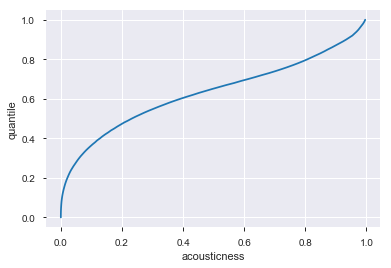

In [28]:
quantile_acou=Spotify['acousticness'].quantile(np.arange(0, 1.01, 0.01).tolist())
quantile_acou=quantile_acou.reset_index()
quantile_acou.rename(columns={'index':'quantile'}, inplace=True)
sns.lineplot(quantile_acou['acousticness'],quantile_acou['quantile'])

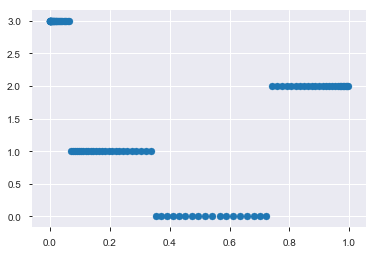

In [29]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(quantile_acou)
quantile_acou['cluster']=kmeans.predict(quantile_acou)
plt.scatter(quantile_acou['acousticness'],quantile_acou['cluster'])

In [30]:
zero=quantile_acou[quantile_acou.cluster==0]
one=quantile_acou[quantile_acou.cluster==1]
two=quantile_acou[quantile_acou.cluster==2]
three=quantile_acou[quantile_acou.cluster==3]
four=quantile_acou[quantile_acou.cluster==4]

min_zero=np.min(zero['acousticness'])
max_zero=np.max(zero['acousticness'])
min_one=np.min(one['acousticness'])
max_one=np.max(one['acousticness'])
min_two=np.min(two['acousticness'])
max_two=np.max(two['acousticness'])
min_three=np.min(three['acousticness'])
max_three=np.max(three['acousticness'])

print(0,min_zero,max_zero)
print(1,min_one,max_one)
print(2,min_two,max_two)
print(3,min_three,max_three)

0 0.354 0.722
1 0.0709 0.337
2 0.7410000000000001 0.996
3 0.0 0.0651


In [31]:
conditions_acou = [
    (Spotify['acousticness'] >= 0.6158599999999996)&(Spotify['acousticness'] <=0.995),
    (Spotify['acousticness'] >= 0.251)& (Spotify['acousticness'] <=0.594),
    (Spotify['acousticness'] >= 0.0363)&(Spotify['acousticness'] <=0.239),
    (Spotify['acousticness'] >= 1.39e-06)&(Spotify['acousticness'] <=0.03276299999999999)]
choices_acou = [3, 2,1,0]
Spotify['label_acou'] = np.select(conditions_acou, choices_acou)

# Features Engineering

1. Analysing features distributions

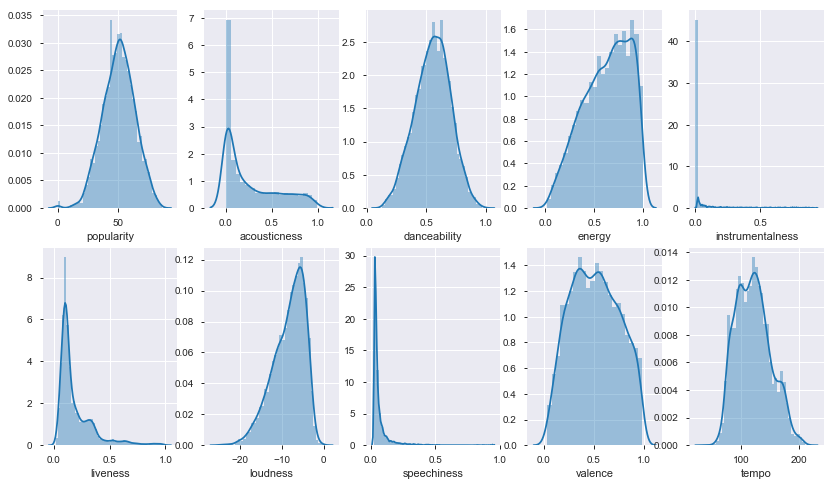

In [32]:
f, axes = plt.subplots(2, 5, figsize=(14, 8), sharex=False)
sns.distplot(song_lyrics['popularity'],ax=axes[0,0])
sns.distplot(song_lyrics['acousticness'],ax=axes[0,1])
sns.distplot(song_lyrics['danceability'],ax=axes[0,2])
sns.distplot(song_lyrics['energy'],ax=axes[0,3])
sns.distplot(song_lyrics['instrumentalness'],ax=axes[0, 4])
sns.distplot(song_lyrics['liveness'],ax=axes[1,0])
sns.distplot(song_lyrics['loudness'],ax=axes[1,1])
sns.distplot(song_lyrics['speechiness'],ax=axes[1,2])
sns.distplot(song_lyrics['valence'],ax=axes[1,3])
sns.distplot(song_lyrics['tempo'],ax=axes[1,4])

(array([ 13.,   1.,   6.,  21.,  28.,  93., 217., 254., 366., 457., 668.,
        645., 640., 689., 427., 301., 250., 122.,  54.,  22.]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ,
        47.3, 51.6, 55.9, 60.2, 64.5, 68.8, 73.1, 77.4, 81.7, 86. ]),
 <a list of 20 Patch objects>)

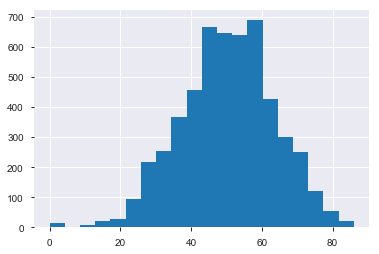

In [33]:
plt.hist(song_lyrics['popularity'], bins=20)

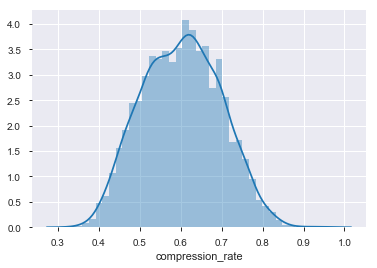

In [34]:
sns.distplot(song_lyrics['compression_rate'])

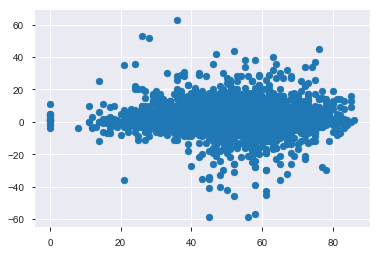

In [35]:
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%+'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%='] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_%-'] )
plt.scatter(song_lyrics['popularity'],song_lyrics['senti_total'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['speechiness'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['speechiness'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['valence'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['compression_rate'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['acousticness'] )

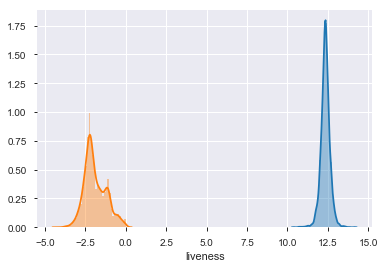

In [40]:
#turning duration_ms to improve this feature
ln_duration_ms = np.log(song_lyrics['duration_ms'])
ln_liveness = np.log(song_lyrics['liveness'])
sns.distplot(ln_duration_ms)
sns.distplot(ln_liveness)

2. Encoding

In [41]:
# renaming data before classification

# track features
genre = song_lyrics['genre'].str.strip()
genre = song_lyrics['genre'].str.lower()
artist_name = song_lyrics['artist_name'].str.strip()
artist_name = song_lyrics['artist_name'].str.lower()
track_name = song_lyrics['track_name']
track_id = song_lyrics['track_id']

# spotify features
popularity = song_lyrics['popularity']
acousticness = song_lyrics['acousticness']
danceability = song_lyrics['danceability']
duration_ms = song_lyrics['duration_ms']
energy = song_lyrics ['energy']
instrumentalness = song_lyrics['instrumentalness']
key = song_lyrics['key']
liveness = song_lyrics['liveness']
loudness = song_lyrics['loudness']
mode = song_lyrics['mode']
speechiness = song_lyrics['speechiness']
tempo = song_lyrics['tempo']
time_signature = song_lyrics['time_signature']
valence = song_lyrics['valence']

# sentimental features
text = song_lyrics['text']
compression_rate = song_lyrics['compression_rate']
senti_positive = song_lyrics['senti_%+']
senti_neutral = song_lyrics['senti_%=']
senti_negative = song_lyrics['senti_%-']
senti_total = song_lyrics['senti_total']

print(senti_total.shape,senti_neutral.shape,senti_negative.shape,senti_positive.shape)

(5274,) (5274,) (5274,) (5274,)


In [42]:
# encoding discrete data

# track features
genre_encoded = pd.get_dummies(genre,prefix='genre', dummy_na=False)
artist_name_encoded = pd.get_dummies(artist_name,prefix='artist_name', dummy_na=False)

# spotify features 
key_encoded = pd.get_dummies(key,prefix='key', dummy_na=False)
mode_encoded = pd.get_dummies(mode,prefix='mode', dummy_na=False)
time_signature_encoded = pd.get_dummies(time_signature,prefix='time_signature', dummy_na=False)
class_acou_encoded = pd.get_dummies(time_signature,prefix='label_acou', dummy_na=False)
#sentimal features 
#senti_positive_enoded = pd.get_dummies(senti_positive,prefix='senti_positive', dummy_na=False)
#senti_neutral_encoded = pd.get_dummies(senti_neutral,prefix='senti_neutral', dummy_na=False)
#senti_negative_encoded = pd.get_dummies(senti_negative,prefix='senti_negative', dummy_na=False)
#senti_total_encoded = pd.get_dummies(senti_total,prefix='senti_total', dummy_na=False)
#class_acou_encoded

In [44]:
final_num=pd.DataFrame({'track_length':song_lyrics['track_length'],'compression_rate':compression_rate,'danceability':danceability,'duration_ms':ln_duration_ms,'energy':energy,'instrumentalness':instrumentalness,'liveness':ln_liveness,'loudness':loudness,'speechiness':speechiness,'tempo':tempo, 'valence':valence,'senti_%+':senti_positive, 'senti_%=':senti_neutral,'senti_%-':senti_negative, 'senti_total':senti_total })
print(final_num.shape)



(5274, 15)


In [45]:
final_num2=pd.DataFrame({'danceability':danceability,'duration_ms':ln_duration_ms,'energy':energy,'instrumentalness':instrumentalness,'liveness':ln_liveness,'loudness':loudness,'speechiness':speechiness,'tempo':tempo, 'valence':valence})
final_num2.shape



(5274, 9)

In [46]:
song_lyrics.shape

(5274, 26)

In [47]:
final_num.shape

(5274, 15)

In [48]:
final_encode=pd.concat([class_acou_encoded,key_encoded,mode_encoded,time_signature_encoded,genre_encoded,artist_name_encoded],axis=1)

In [49]:
final_encode.shape

(5274, 460)

In [50]:
final=pd.concat([final_num,final_encode],axis=1)


In [51]:
label=song_lyrics['label']

In [52]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(final, label, test_size = 0.2, random_state = 1)

In [53]:
yTest.shape

(1055,)

In [54]:
RFC_Model = RandomForestClassifier()
RFC_Model.fit(xTrain, yTrain)
RFC_Predict = RFC_Model.predict(xTest)
RFC_Accuracy = accuracy_score(yTest, RFC_Predict)
print("Accuracy: " + str(RFC_Accuracy))

#RFC_AUC = roc_auc_score(yTest, RFC_Predict) 
#print("AUC: " + str(RFC_AUC))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.7914691943127962


In [55]:
KNN_Model = KNeighborsClassifier(n_neighbors=5)
KNN_Model.fit(xTrain, yTrain)
KNN_Predict = KNN_Model.predict(xTest)
KNN_Accuracy = accuracy_score(yTest, KNN_Predict)
print("Accuracy: " + str(KNN_Accuracy))

Accuracy: 0.609478672985782


In [56]:
LR_Model = LogisticRegression()
LR_Model.fit(xTrain, yTrain)
LR_Predict = LR_Model.predict(xTest)
LR_Accuracy = accuracy_score(yTest, LR_Predict)
print("Accuracy: " + str(LR_Accuracy))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.8502369668246446


In [57]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(xTrain, yTrain)
ada_pred = ada.predict(xTest)
ada_Accuracy = accuracy_score(yTest, ada_pred)
print("Accuracy: " + str(ada_Accuracy))

Accuracy: 0.837914691943128


In [58]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
nb_pred = gnb.fit(xTrain, yTrain).predict(xTest)
nb_Accuracy = accuracy_score(yTest, nb_pred)
print("Accuracy: " + str(nb_Accuracy))

Accuracy: 0.7004739336492891
